In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

In [ ]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

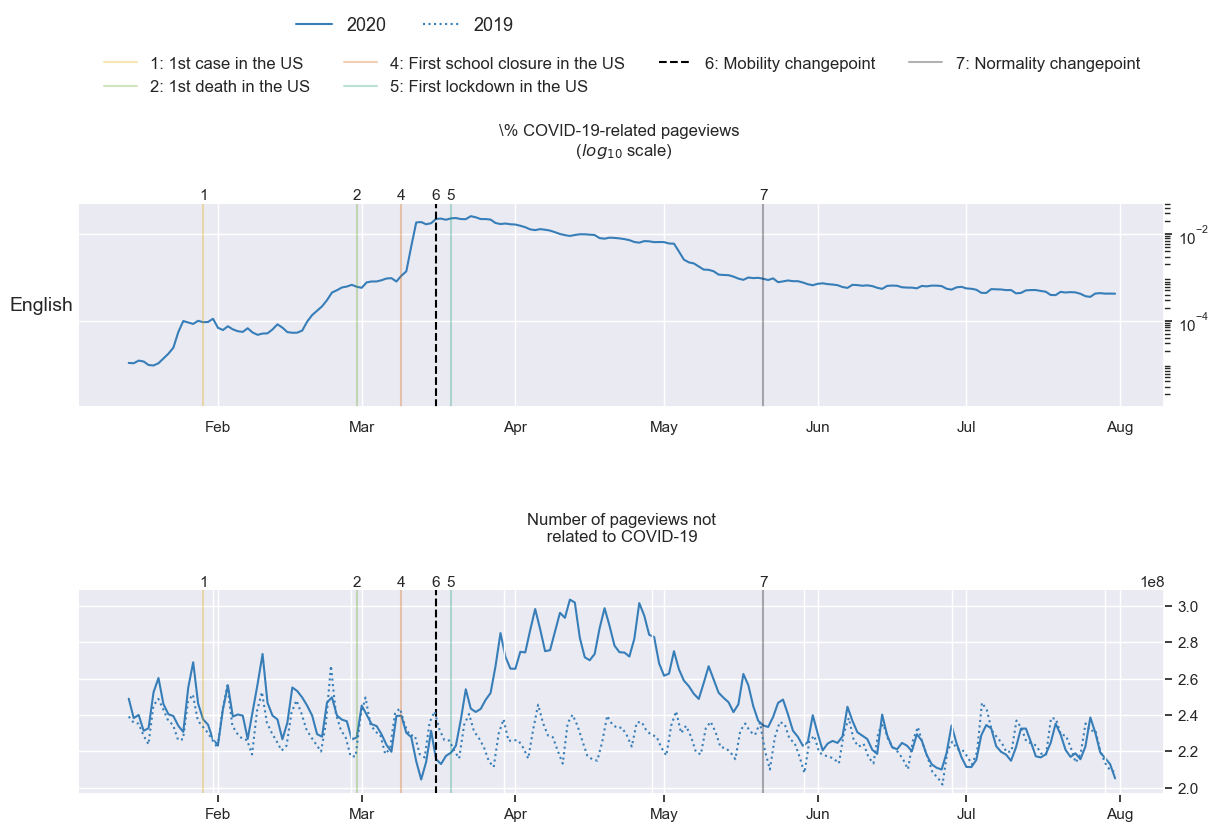

In [ ]:
# COVID-RELATED PAGEVIEWS
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})

ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

# NON COVID-RELATED PAGEVIEWS

ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_dates(ax_twin, 20190114, 20190731, agg[code]["sum"].index,
           agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
           agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values,
           adjust=(start, end), sci=False, xticklabels=False, ls=":", color="#377eb8")

#axs[0].plot(gtrends_hydro_df['Views']/3e5, color='blue', linewidth=1)
#[axs[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
#axs[1].plot(gtrends_hydro_df['Views']*7e6, color='blue', linewidth=1)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')
    
#[axs[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axs[0].set_title("\% COVID-19-related pageviews \n ($log_{10}$ scale)", pad=35)
axs[1].set_title("Number of pageviews not\n related to COVID-19 ", pad=35)


lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls=":"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["2020", "2019"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)


lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)